# Simple DFT based seizure anticipation classifier

In [136]:
import numpy as np
import pandas as pd
import scipy.io
import os
import mne
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [157]:
import imp 
imp.reload(ief) 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [5]:
# Import Clinical Szr Onset Times
sub='NA'
onset_csv_dir='/Users/davidgroppe/Dropbox/TWH_INFO/ONSET_TIMES_CLINICAL/'
onset_csv_fname=os.path.join(onset_csv_dir,sub+'_clinical_onset_offset.csv')
print('Importing file %s' % onset_csv_fname)
onset_df=pd.read_csv(onset_csv_fname)

Importing file /Users/davidgroppe/Dropbox/TWH_INFO/ONSET_TIMES_CLINICAL/NA_clinical_onset_offset.csv


In [68]:
onset_df.head()

,DAY,SZR#,ONSET,OFFSET,SOZ_CHAN,FILE_ONSET,DDMMYR,SRATE_HZ,NOTES,ONSET_SEC,FILE_ONSET_SEC,ONSET_TPT
0,1,1,8:59:03 PM,9:38:35 PM,?,?,06/23/2009,500,?,75543,NaN,NaN
1,1,2,1:54:41 AM,1:55:52 AM,RHD1,1:52:45,06/23/2009,500,?,6881,6765.0,58000.0
2,1,3,2:42:25 AM,2:43:58 AM,?,2:39:36,06/23/2009,500,?,9745,9576.0,84500.0
3,1,4,4:51:59 AM,4:53:35 AM,?,4:49:03,06/23/2009,500,?,17519,17343.0,88000.0
4,1,5,6:29:14 AM,6:31:11 AM,?,6:26:20,06/23/2009,500,?,23354,23180.0,87000.0


In [69]:
def clin_onset_tpt(szr_name, onset_df):
    import re
    szr_name='NA_d1_sz2.mat'
    name_splt=szr_name.split('_')
    day=int(name_splt[1][1:])
    szr=int(re.findall('[0-9]+',name_splt[2])[0])
    print('Getting clinical onset time for %s: Day %d, Szr %d' % (name_splt[0],day,szr))

    # temp_df=onset_df[onset_df['DAY']==day and onset_df['SZR#']==2]
    day_ids=onset_df[onset_df['DAY']==day].index 
    szr_ids=onset_df[onset_df['SZR#']==szr].index 
    use_id=day_ids.intersection(szr_ids)
    onset_tpt=onset_df['ONSET_TPT'].iloc[use_id].values[0]
    return onset_tpt

onset_tpt=clin_onset_tpt(szr_name, onset_df)

Getting clinical onset time for NA: Day 1, Szr 2


In [100]:
# Import Data
szr_name='NA_d1_sz2.mat'
ieeg_dir=os.path.join('/Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/',sub,'Data')
ieeg_fname=os.path.join(ieeg_dir,szr_name)
print('Loading %s' % ieeg_fname)
mat=scipy.io.loadmat(ieeg_fname)
Sf=mat['Sf'][0]
ieeg=mat['matrix_bi']
ieeg=ieeg.T
n_chan, n_tpt=ieeg.shape
tpts_sec=np.arange(0,n_tpt)/Sf
tpts_sec=tpts_sec.T
# Import Channel Labels
chan_fname=os.path.join('/Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/',sub,
                        sub+'_channel_info.csv')
print('Loading %s' % chan_fname)
chan_labels_df=pd.read_csv(chan_fname,names=['label'])
# Convert to list and remove redundant electrode stem for second electrode in each bipolar pair
chan_labels=ief.clean_labels(list(chan_labels_df['label']))

onset_chan_id=12; #RHD1-2

Loading /Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/NA/Data/NA_d1_sz2.mat
Loading /Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/NA/NA_channel_info.csv


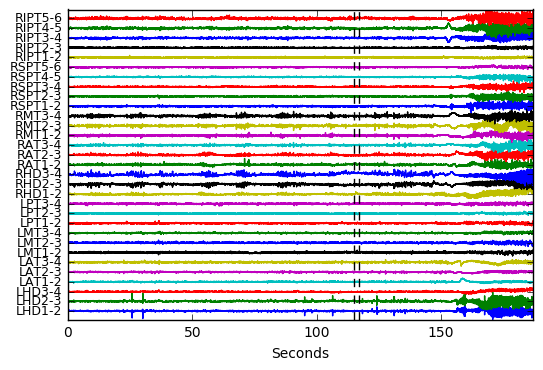

In [112]:
# Plot voltage time series and onset
[h, ax]=ief.strat_plot(ieeg,chan_labels,tpts_sec=tpts_sec)

onset_upper_bnd_sec=(onset_tpt/Sf)+1
onset_lower_bnd_sec=(onset_tpt/Sf)-1
ylim=ax.get_ylim()
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')

In [169]:
sgram_pos=np.exp(sgram.copy()/10)
np.max(sgram_pos)
onset_chan_id

12

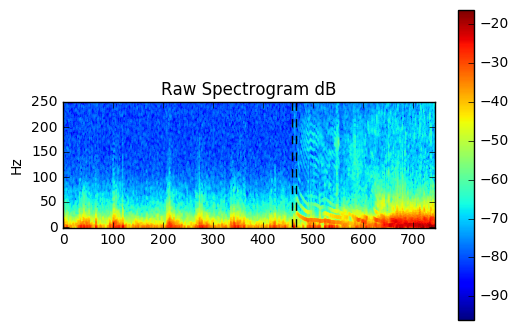

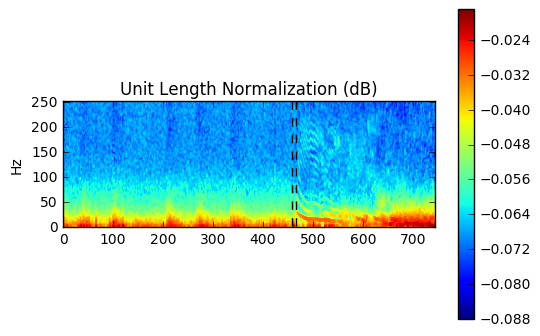

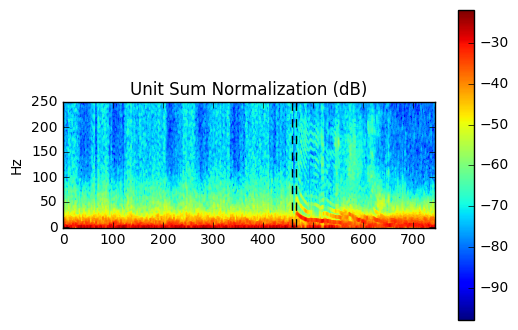

In [170]:
# Compute spectrogram for onset channel
sgram, f, sgram_sec=ief.mt_sgram(ieeg[onset_chan_id,:],Sf,Sf,Sf/4,4,tpts_sec)
# ief.z_norm(sgram,sgram_sec,onset_tpt)

# Raw Spectrogram (dB)
plt.figure(2)
plt.clf()
plt.imshow(sgram)
onset_sgram_tpt_lower=dg.find_nearest(sgram_sec,onset_lower_bnd_sec)
onset_sgram_tpt_upper=dg.find_nearest(sgram_sec,onset_upper_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k--')
plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k--')
plt.ylim(ylim)
plt.xlim([0,len(sgram_sec)])
plt.ylabel('Hz')
plt.gca().invert_yaxis()
plt.title('Raw Spectrogram dB')
plt.colorbar()

# Column normalized spectrogram (column vectors have length 1)
sgram_nrm=preprocessing.normalize(sgram,axis=0)
plt.figure(3)
plt.clf()
plt.imshow(sgram_nrm)
ylim=plt.ylim()
plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k--')
plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k--')
plt.ylim(ylim)
plt.xlim([0,len(sgram_sec)])
plt.ylabel('Hz')
plt.gca().invert_yaxis()
plt.title('Unit Length Normalization (dB)')
plt.colorbar()

sgram_pos=np.exp(sgram.copy()/10)
sgram_pos=sgram_pos/np.sum(sgram_pos,axis=0)
use_db=True
if use_db:
    sgram_pos=10*np.log(sgram_pos)
plt.figure(4)
plt.clf()
plt.imshow(sgram_pos)
ylim=plt.ylim()
plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k--')
plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k--')
plt.ylim(ylim)
plt.xlim([0,len(sgram_sec)])
plt.ylabel('Hz')
plt.gca().invert_yaxis()
if use_db:
    plt.title('Unit Sum Normalization (dB)')
else:
    plt.title('Unit Sum Normalization not-dB')
plt.colorbar()

In [159]:
bands=list()
bands.append((1,4)) # Delta
bands.append((4,8)) # Theta
bands.append((8,13)) # Alpha
bands.append((13,30)) # Beta
bands.append((30,50)) # Gamma
bands.append((70,100)) # High Gamma (this skips 60 Hz DC and accommodates 250 Hz Sf, 
# 40% of Sf is max freq you want to examine)

In [177]:
# Average dB power by frequency band and plot their time series
imp.reload(ief) 
[db_pwr, sgram_sec]=ief.bp_pwr(ieeg,Sf,Sf,int(Sf/4),4,tpts_sec,bands)

(31, 6, 744)


(0.499, 186.249)

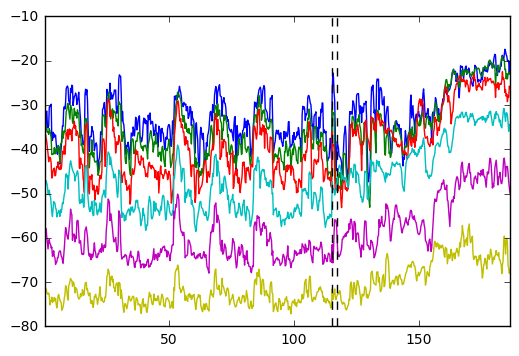

In [181]:
print(db_pwr.shape)
_=plt.plot(sgram_sec,db_pwr[onset_chan_id,:,:].T)
onset_sgram_tpt_lower=dg.find_nearest(sgram_sec,onset_lower_bnd_sec)
onset_sgram_tpt_upper=dg.find_nearest(sgram_sec,onset_upper_bnd_sec)
ylim=plt.ylim()
plt.plot([sgram_sec[onset_sgram_tpt_upper], sgram_sec[onset_sgram_tpt_upper]],ylim,'k--')
plt.plot([sgram_sec[onset_sgram_tpt_lower], sgram_sec[onset_sgram_tpt_lower]],ylim,'k--')
plt.ylim(ylim)
plt.xlim([sgram_sec[0], sgram_sec[-1]])

In [ ]:
# Compute spectrogram for onset channel using MNE?
from mne.time_frequency import psd_multitaper
fmin, fmax=0, int(Sf/2)
n_fft=512 #TODO make this a function of Sf
psds, freqs = psd_multitaper(raw, low_bias=True, tmin=tmin, tmax=tmax,
                             fmin=fmin, fmax=fmax, proj=True, picks=picks,
                             n_jobs=1)
# mne.connectivity.spectral_connectivity

In [92]:
from mne.time_frequency import tfr_multitaper
from mne import create_info, EpochsArray
EpochsArray?

In [ ]:
from mne.time_frequency import tfr_multitaper

In [ ]:
tfr_multitaper(inst, freqs, n_cycles, time_bandwidth=4.0, 
               use_fft=True, return_itc=True, decim=1, n_jobs=1, picks=None, average=True, verbose=None)

In [20]:
# mne.set_config('MNE_LOGGING_LEVEL', 'INFO', set_env=True)

Attempting to create new mne-python configuration file:
/Users/davidgroppe/.mne/mne-python.json


In [27]:
# from mne.time_frequency import istft
# istft?
# dpss_windows?

In [ ]:
# Plot Features Time Locked to Onset